In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.interpolate import interp1d

In [2]:
csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')

ls_df = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0')[['Tuned LS PBE', 'Tuned LS SCAN']]
hs_df = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0')[['Tuned HS PBE', 'Tuned HS SCAN']]

for idx, row in csd_hfx_df.iterrows():
    if np.isnan(row['hfx_pbe']):
        ls_df.loc[idx, 'Tuned LS PBE'] = np.nan
        hs_df.loc[idx, 'Tuned HS PBE'] = np.nan
    if np.isnan(row['hfx_scan']):
        ls_df.loc[idx, 'Tuned LS SCAN'] = np.nan
        hs_df.loc[idx, 'Tuned HS SCAN'] = np.nan

csd_racs_df = pd.read_csv('../ml_training/RACs/csd_racs_predictions.csv').set_index('Unnamed: 0')
vss_racs_df = pd.read_csv('../ml_training/RACs/vss_racs_predictions.csv').set_index('Unnamed: 0')

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)

#to get the energy errors
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
#rename so that the convention matches the original VSS-452
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

def pred_energy(structure, dataset, functional, pred_hfx):
    #structure is the name of the complex, dataset is whether the structure is from vss or csd, 
    #functional is the functional used
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

def get_energy_error(pred_df, pred_name, functional, dataset):
    errors = []
    if dataset == 'csd':
        df = csd_76
    else:
        df = vss_452
    for idx, row in pred_df.iterrows():
        if np.isnan(row[pred_name]):
            continue
        pred = pred_energy(idx, dataset, functional, row[pred_name])
        errors.append(pred - df.loc[idx]['dlpno-CCSD_T.vertsse'])
    return np.mean(np.abs(np.array(errors)))

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

Text(1, 85, 'MAE = 7.8 HFX% \nMAE = 5.9 kcal/mol')

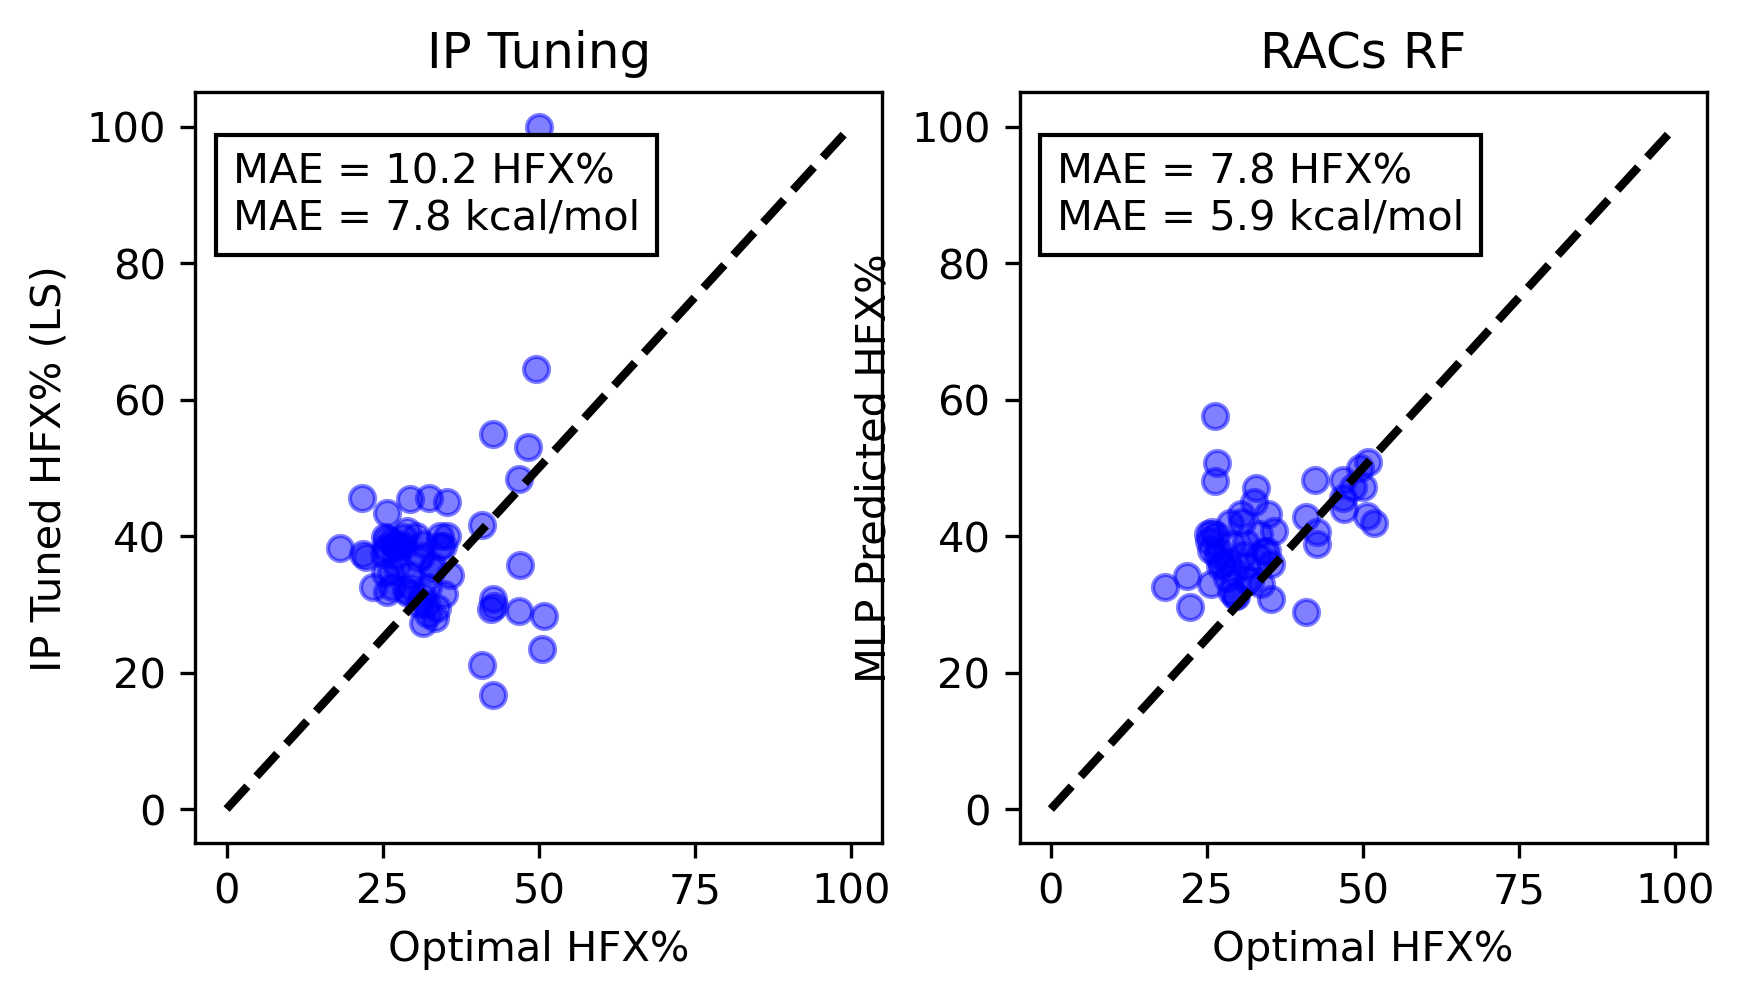

In [3]:
#for optimal tuning
ls_pbe = []
ls_actual_pbe = []

ls_scan = []
ls_actual_scan = []

for idx, ls_row in ls_df.iterrows():
    row = csd_hfx_df.loc[idx]
    if not np.isnan(ls_row['Tuned LS PBE']) and not np.isnan(row['hfx_pbe']):
        ls_pbe.append(ls_row['Tuned LS PBE'])
        ls_actual_pbe.append(row['hfx_pbe'])

#for RACs-ML
racs_pbe = []
racs_actual_pbe = []

for idx, racs_row in csd_racs_df.iterrows():
    row = csd_hfx_df.loc[idx]
    if not np.isnan(racs_row['pbe-rf-1234']) and not np.isnan(row['hfx_pbe']):
        racs_pbe.append(racs_row['pbe-rf-1234'])
        racs_actual_pbe.append(row['hfx_pbe'])

tuned_err = get_energy_error(ls_df, 'Tuned LS PBE', 'pbe', 'csd')
racs_err = get_energy_error(csd_racs_df, 'pbe-rf-1234', 'pbe', 'csd')

pts = np.arange(0, 101, 1)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6.5, 3.25), dpi=300)
ax[0].set_title('IP Tuning')
ax[0].set_xlabel('Optimal HFX%')
ax[0].set_ylabel('IP Tuned HFX% (LS)')
ax[1].set_title('RACs RF')
ax[1].set_xlabel('Optimal HFX%')
ax[1].set_ylabel('MLP Predicted HFX%')
ax[0].set_ylim((-5, 105))
ax[1].set_ylim((-5, 105))
ax[0].set_xlim((-5, 105))

ax[0].scatter(ls_actual_pbe, ls_pbe, color='#0000FF', alpha=0.5)
ax[0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0].text(1, 85, f'MAE = {np.abs(np.array(ls_actual_pbe)-np.array(ls_pbe)).mean():1.1f} HFX% \nMAE = {tuned_err:1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1].scatter(racs_actual_pbe, racs_pbe, color='#0000FF', alpha=0.5)
ax[1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1].text(1, 85, f'MAE = {np.abs(np.array(racs_actual_pbe)-np.array(racs_pbe)).mean():1.1f} HFX% \nMAE = {racs_err:1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

Text(1, 85, 'MAE = 5.1 HFX% \nMAE = 3.9 kcal/mol')

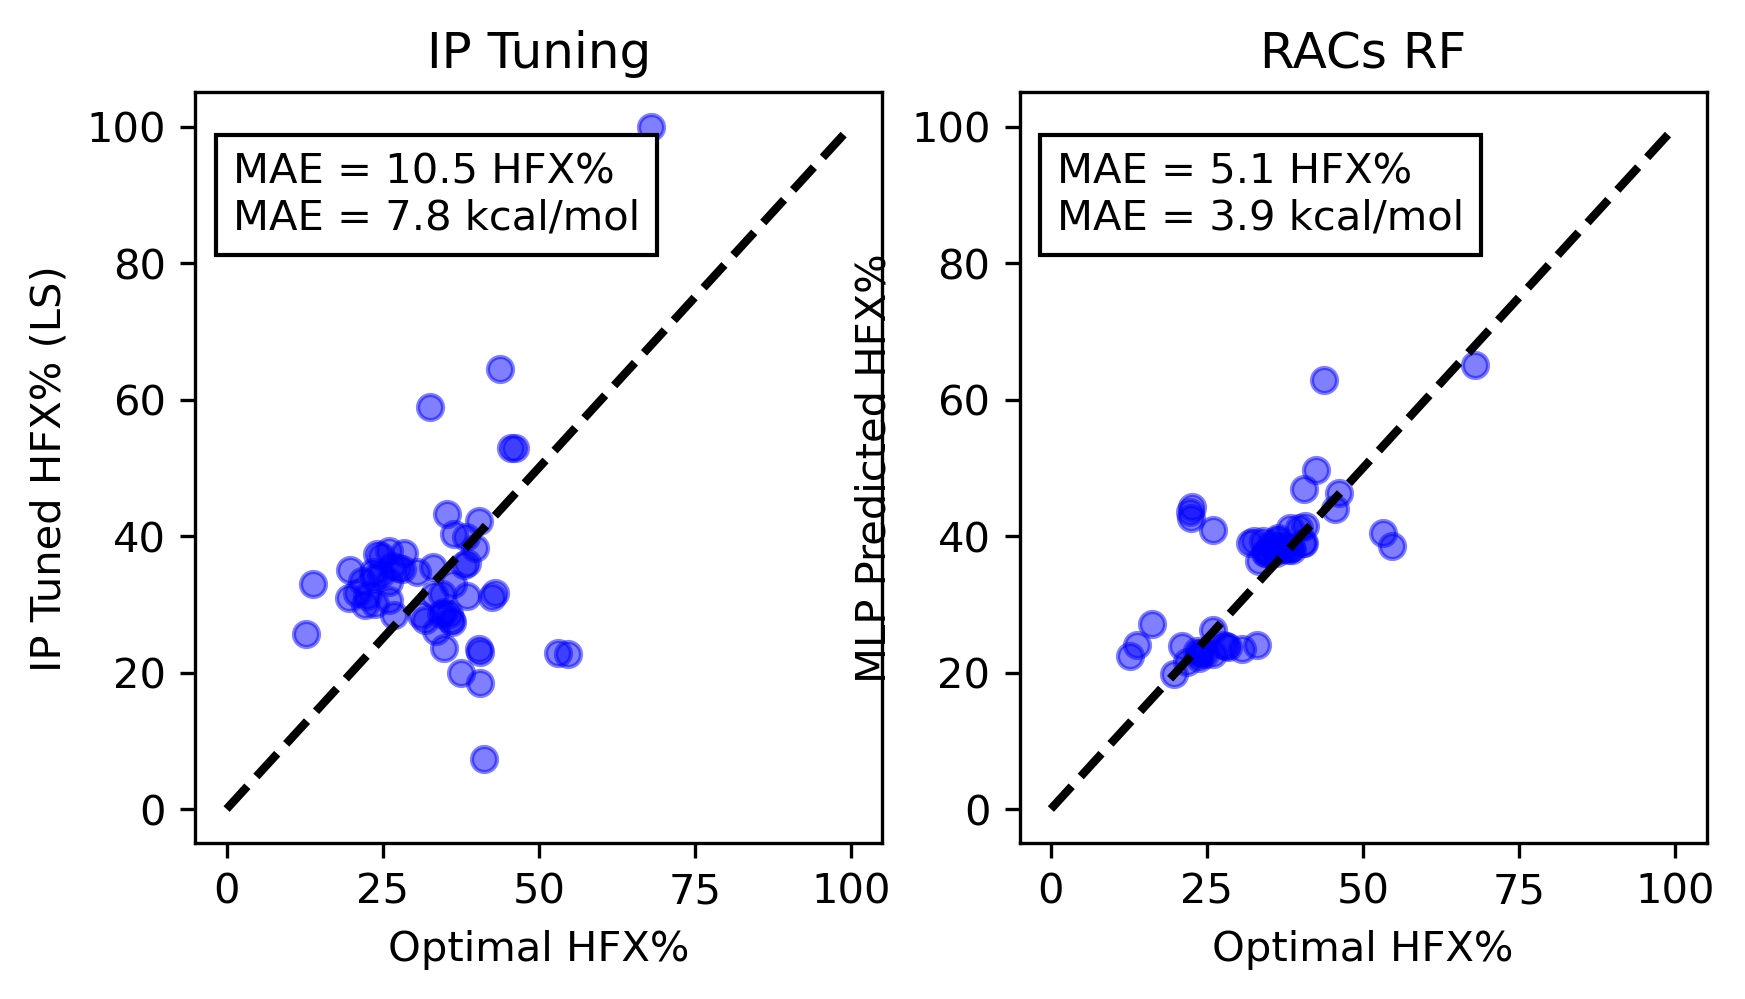

In [4]:
#figure S13, same ass figure 5 but for SCAN

ls_scan = []
ls_actual_scan = []

for idx, ls_row in ls_df.iterrows():
    row = csd_hfx_df.loc[idx]
    if not np.isnan(ls_row['Tuned LS SCAN']) and not np.isnan(row['hfx_scan']):
        ls_scan.append(ls_row['Tuned LS SCAN'])
        ls_actual_scan.append(row['hfx_scan'])

#for RACs-ML
racs_scan = []
racs_actual_scan = []

for idx, racs_row in csd_racs_df.iterrows():
    row = csd_hfx_df.loc[idx]
    if not np.isnan(racs_row['scan-rf-1234']) and not np.isnan(row['hfx_scan']):
        racs_scan.append(racs_row['scan-rf-1234'])
        racs_actual_scan.append(row['hfx_scan'])

tuned_err = get_energy_error(ls_df, 'Tuned LS SCAN', 'scan', 'csd')
racs_err = get_energy_error(csd_racs_df, 'scan-rf-1234', 'scan', 'csd')

pts = np.arange(0, 101, 1)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6.5, 3.25), dpi=300)
ax[0].set_title('IP Tuning')
ax[0].set_xlabel('Optimal HFX%')
ax[0].set_ylabel('IP Tuned HFX% (LS)')
ax[1].set_title('RACs RF')
ax[1].set_xlabel('Optimal HFX%')
ax[1].set_ylabel('MLP Predicted HFX%')
ax[0].set_ylim((-5, 105))
ax[1].set_ylim((-5, 105))
ax[0].set_xlim((-5, 105))

ax[0].scatter(ls_actual_scan, ls_scan, color='#0000FF', alpha=0.5)
ax[0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0].text(1, 85, f'MAE = {np.abs(np.array(ls_actual_scan)-np.array(ls_scan)).mean():1.1f} HFX% \nMAE = {tuned_err:1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1].scatter(racs_actual_scan, racs_scan, color='#0000FF', alpha=0.5)
ax[1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1].text(1, 85, f'MAE = {np.abs(np.array(racs_actual_scan)-np.array(racs_scan)).mean():1.1f} HFX% \nMAE = {racs_err:1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))